In [21]:
import math
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
%matplotlib inline

# For interactive plots in Jupyter
%config InlineBackend.close_figures = False
plt.ion()

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.children = []
        self.cost = 0.0

class Obstacle:
    """Class to represent obstacles in the environment"""
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        
    def contains(self, point):
        """Check if a point is inside the obstacle"""
        x, y = point
        return (self.x <= x <= self.x + self.width and 
                self.y <= y <= self.y + self.height)
    
    def plot(self, ax, color='red'):
        """Plot the obstacle on the given axes"""
        rect = Rectangle((self.x, self.y), self.width, self.height, 
                         color=color, alpha=0.5)
        ax.add_patch(rect)

class RRTStar():
    def __init__(self, max_iters=700):
        self.max_iters = int(max_iters)
        self.step_size = 0.5
        self.goal_threshold = 0.5
        self.goal_bias = 0.1
        self.search_space = (-2, -2, 12, 12)  # x_min, y_min, x_max, y_max
        self.rewire_radius = 1.5  # Radius for rewiring in RRT*
        
        plt.close('all')
        self.fig, self.ax = plt.subplots(figsize=(10, 10))

        self.nodes = []
        self.obstacles = []
        self.path = []
        self.best_path_cost = float('inf')
        self.best_goal_node = None
        
        self.x_min = self.search_space[0]
        self.x_max = self.search_space[2]
        self.y_min = self.search_space[1]
        self.y_max = self.search_space[3]

    
    def plot_tree(self, start_node, goal_node, final_path=False):
        """Visualize the RRT tree"""
        self.ax.clear()
        
        # Set up the plot
        self.ax.set_xlim(self.search_space[0], self.search_space[2])
        self.ax.set_ylim(self.search_space[1], self.search_space[3])
        self.ax.set_aspect('equal')
        self.ax.grid(True)
        
        # Plot start and goal
        self.ax.plot(start_node.x, start_node.y, 'go', markersize=10)
        self.ax.plot(goal_node.x, goal_node.y, 'ro', markersize=10)
        
        # Plot obstacles
        for obstacle in self.obstacles:
            obstacle.plot(self.ax)
        
        # Plot the tree
        for node in self.nodes:
            if node.parent is not None:
                self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], 'b-', alpha=0.3)
        
        # Plot the final path if requested
        if final_path and self.path:
            path_x = [p[0] for p in self.path]
            path_y = [p[1] for p in self.path]
            self.ax.plot(path_x, path_y, 'g-', linewidth=2)
        
        plt.title("RRT Path Planning")
        plt.draw()
        plt.pause(0.01)

    def build_path(self, node):
        """Build the path from start to goal"""
        path = []
        while node is not None:
            path.append((node.x, node.y))
            node = node.parent
        return path[::-1]  # Reverse to get start-to-goal order

    def add_obstacle(self, obstacle):
        """Add obstacle to the environment"""
        self.obstacles.append(obstacle)
        
    def collision_free(self, from_node_x, from_node_y, to_node_x, to_node_y):
        """Check if path between nodes is collision-free"""
        for obstacle in self.obstacles:
            if self.line_intersects_obstacle(from_node_x, from_node_y, to_node_x, to_node_y, obstacle):
                return False
        return True
    
    def line_intersects_obstacle(self, from_node_x, from_node_y, to_node_x, to_node_y, obstacle):
        """Check if line segment intersects obstacle"""
        steps = 20
        for i in range(steps + 1):
            t = i / steps
            x = from_node_x + t * (to_node_x - from_node_x)
            y = from_node_y + t * (to_node_y - from_node_y)
            if obstacle.contains((x, y)):
                return True
        return False
        
    def euclid_distance(self, x1, x2, y1, y2):
        return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    def sample(self, goal_node):
        """Randomly sample a point in the search space"""
        # With goal_bias probability, sample the goal directly
        if random.random() < self.goal_bias:
            return goal_node.x, goal_node.y
        
        # Otherwise sample uniformly in the search space
        x = random.uniform(self.x_min, self.x_max)
        y = random.uniform(self.y_min, self.y_max)
        return (x, y)

    def nearest_neighbor(self, point: tuple):
        """Find the node that is a nearest neighbor to the point"""
        x, y = point
        min_distance = float('inf')
        the_node = None
        for node in self.nodes:
            distance = self.euclid_distance(x, node.x, y, node.y)
            if distance < min_distance:
                min_distance = distance
                the_node = node
        return the_node

    def steer(self, from_x, from_y, to_x, to_y):
        """Steer from one point toward another"""
        dx = to_x - from_x
        dy = to_y - from_y
        distance = math.sqrt(dx**2 + dy**2)
        
        if distance <= self.step_size:
            return (to_x, to_y)
        
        theta = math.atan2(dy, dx)
        new_x = from_x + self.step_size * math.cos(theta)
        new_y = from_y + self.step_size * math.sin(theta)
        
        return (new_x, new_y)

    def find_near_nodes(self, new_node):
        """Find nodes within rewire radius of the new node"""
        near_nodes = []
        for node in self.nodes:
            distance = self.euclid_distance(new_node.x, node.x, new_node.y, node.y)
            if distance <= self.rewire_radius:
                near_nodes.append(node)
        return near_nodes

    def choose_parent(self, new_node, near_nodes):
        """Choose the best parent for new_node from near_nodes"""
        best_node = new_node.parent
        best_cost = new_node.cost
        
        for node in near_nodes:
            # Check if path from node to new_node is collision-free
            if self.collision_free(node.x, node.y, new_node.x, new_node.y):
                # Calculate cost from start to new_node through node
                cost = node.cost + self.euclid_distance(new_node.x, node.x, new_node.y, node.y)
                
                if cost < best_cost:
                    best_cost = cost
                    best_node = node
        
        # Update new_node's parent and cost
        if best_node != new_node.parent:
            # Remove new_node from old parent's children
            if new_node.parent and new_node in new_node.parent.children:
                new_node.parent.children.remove(new_node)
            
            # Set new parent
            new_node.parent = best_node
            new_node.cost = best_cost
            best_node.children.append(new_node)
        
        return new_node

    def rewire(self, new_node, near_nodes):
        """Rewire the tree: check if nodes in near_nodes can get a better path through new_node"""
        for node in near_nodes:
            # Skip if node is the parent or the same node
            if node == new_node.parent or node == new_node:
                continue
            
            # Check if path from new_node to node is collision-free
            if self.collision_free(new_node.x, new_node.y, node.x, node.y):
                # Calculate cost from start to node through new_node
                new_cost = new_node.cost + self.euclid_distance(new_node.x, node.x, new_node.y, node.y)
                
                # If new path is better, rewire
                if new_cost < node.cost:
                    # Remove node from old parent's children
                    if node.parent and node in node.parent.children:
                        node.parent.children.remove(node)
                    
                    # Update parent and cost
                    node.parent = new_node
                    node.cost = new_cost
                    new_node.children.append(node)

    def run_rrt_star(self, start_position: list, goal_position: list):
        """Run RRT* algorithm"""
        start_node = Node(start_position[0], start_position[1])
        goal_node = Node(goal_position[0], goal_position[1])
        self.nodes.append(start_node)
        
        found_path = False
        
        for i in range(self.max_iters):
            if i % 50 == 0:
                self.plot_tree(start_node, goal_node)
            
            # Sample a random point
            point = self.sample(goal_node)
            x_point, y_point = point
            
            # Find nearest node
            nearest_node = self.nearest_neighbor(point)
            
            # Steer from nearest node toward the sampled point
            new_point = self.steer(nearest_node.x, nearest_node.y, x_point, y_point)
            
            # Check if path is collision-free
            if not self.collision_free(nearest_node.x, nearest_node.y, new_point[0], new_point[1]):
                continue
            
            # Create new node
            new_node = Node(new_point[0], new_point[1])
            new_node.parent = nearest_node
            new_node.cost = nearest_node.cost + self.euclid_distance(new_point[0], nearest_node.x, new_point[1], nearest_node.y)
            
            # Find near nodes for rewiring
            near_nodes = self.find_near_nodes(new_node)
            
            # Choose the best parent for new_node
            new_node = self.choose_parent(new_node, near_nodes)
            
            # Add new node to the tree
            self.nodes.append(new_node)
            
            # Rewire the tree
            self.rewire(new_node, near_nodes)
            
            # Check if we've reached the goal
            distance_to_goal = self.euclid_distance(new_node.x, goal_node.x, new_node.y, goal_node.y)
            if distance_to_goal <= self.goal_threshold:
                found_path = True
                
                # Create a goal node connected to new_node
                goal_node.parent = new_node
                goal_node.cost = new_node.cost + distance_to_goal
                
                # Update best path if this one is better
                if goal_node.cost < self.best_path_cost:
                    self.best_path_cost = goal_node.cost
                    self.best_goal_node = goal_node
                    self.path = self.build_path(goal_node)
        
        # After all iterations, plot the final best path
        if found_path:
            self.plot_tree(start_node, goal_node, final_path=True)
            return True, self.max_iters, self.best_path_cost
        else:
            return False, self.max_iters, float('inf')

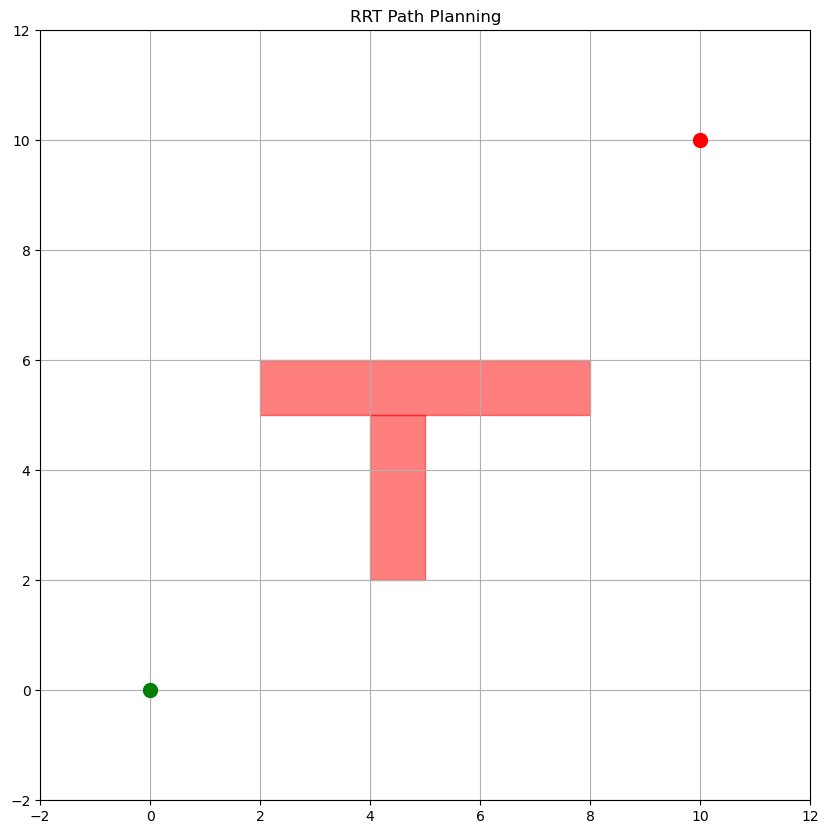

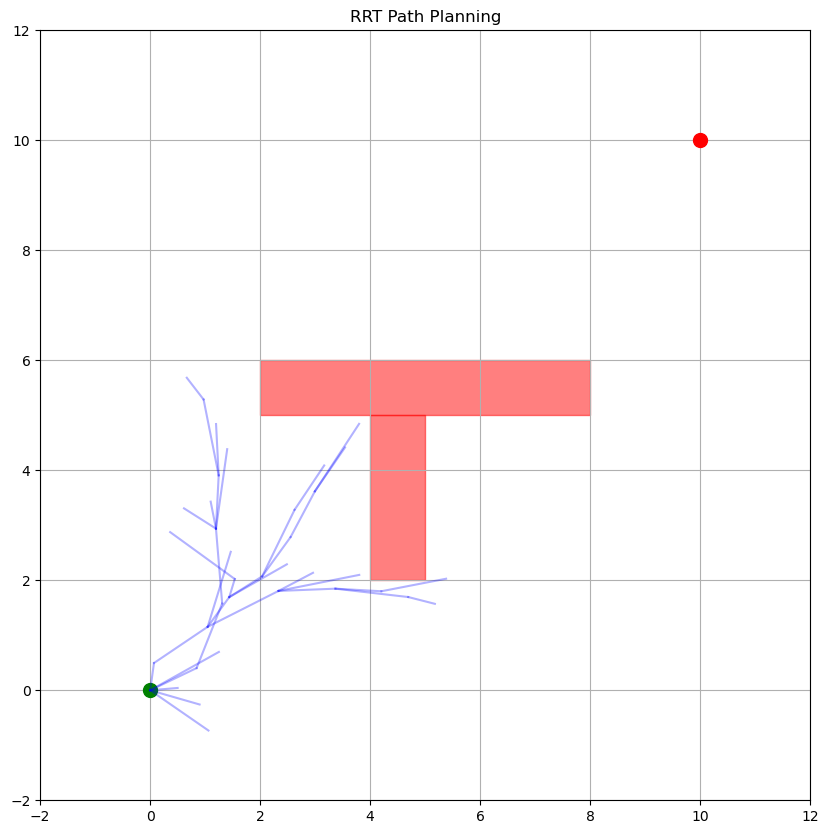

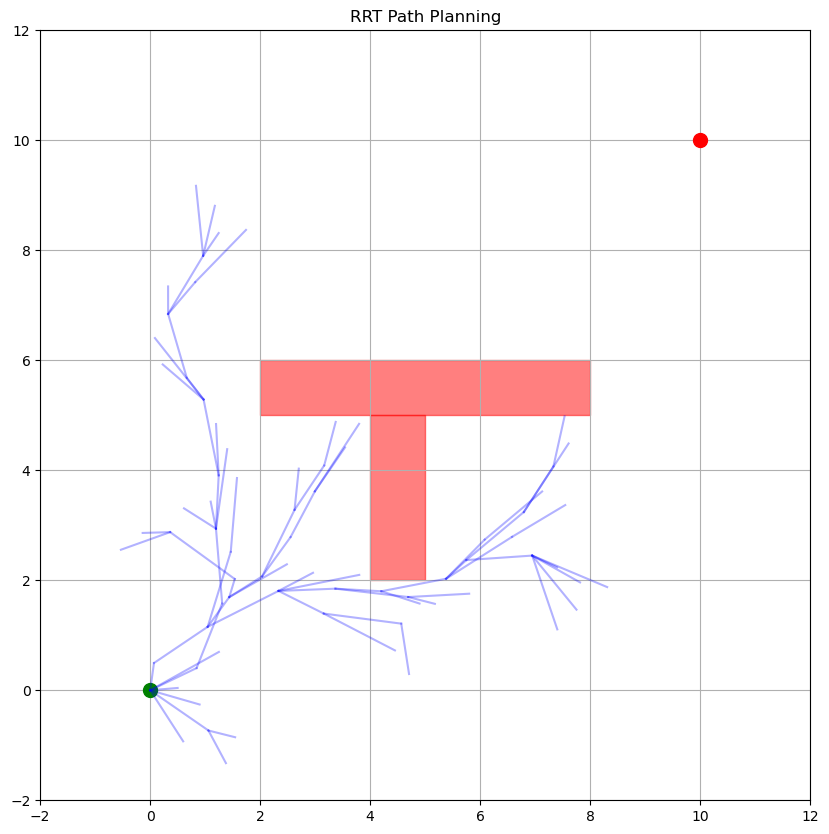

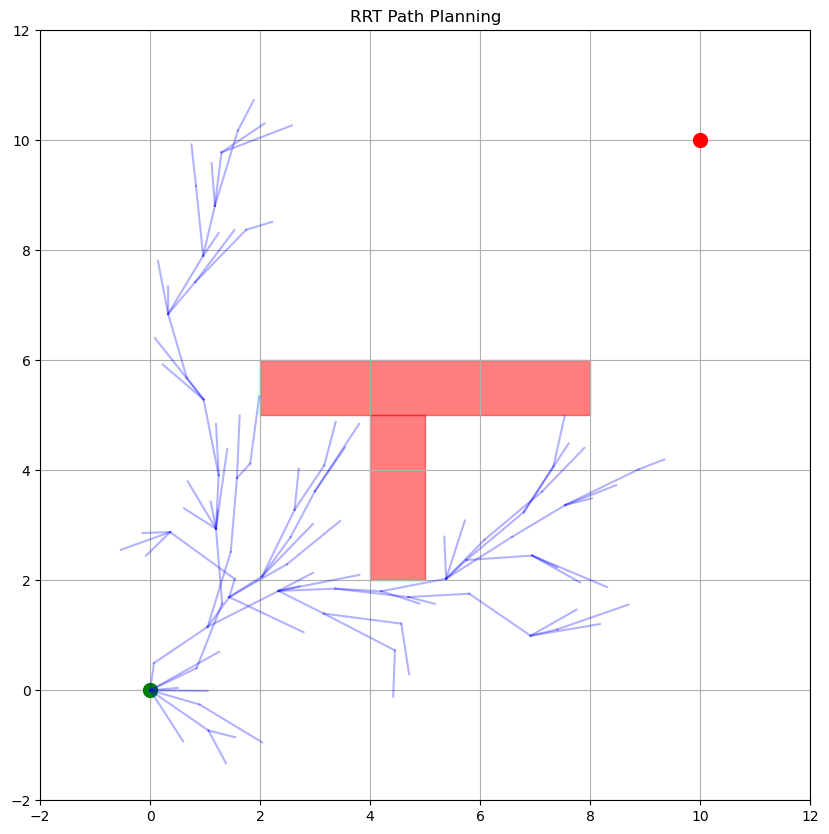

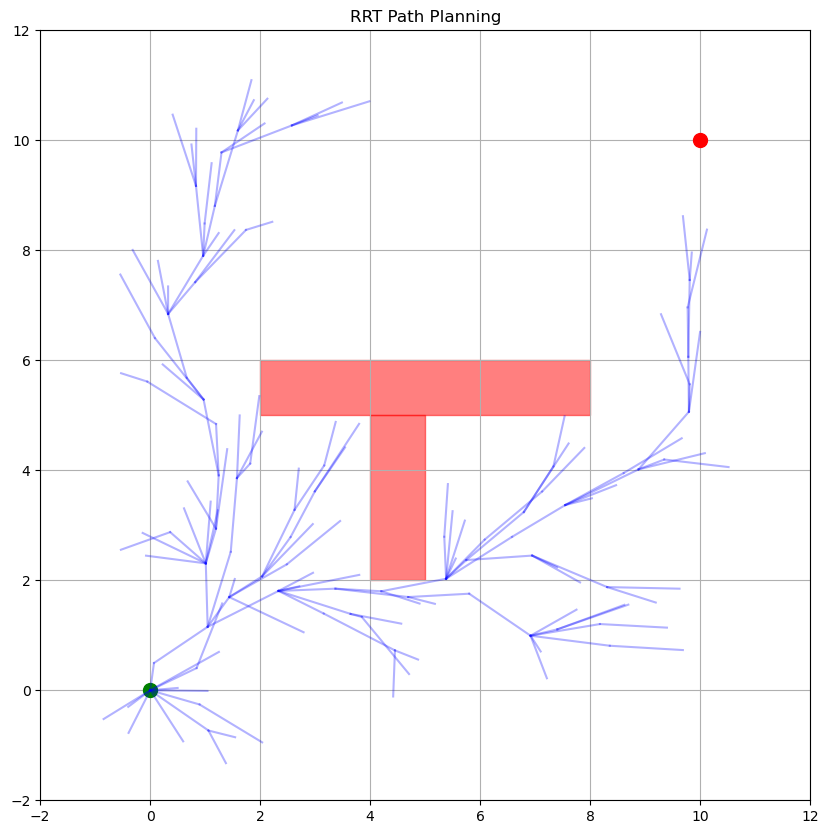

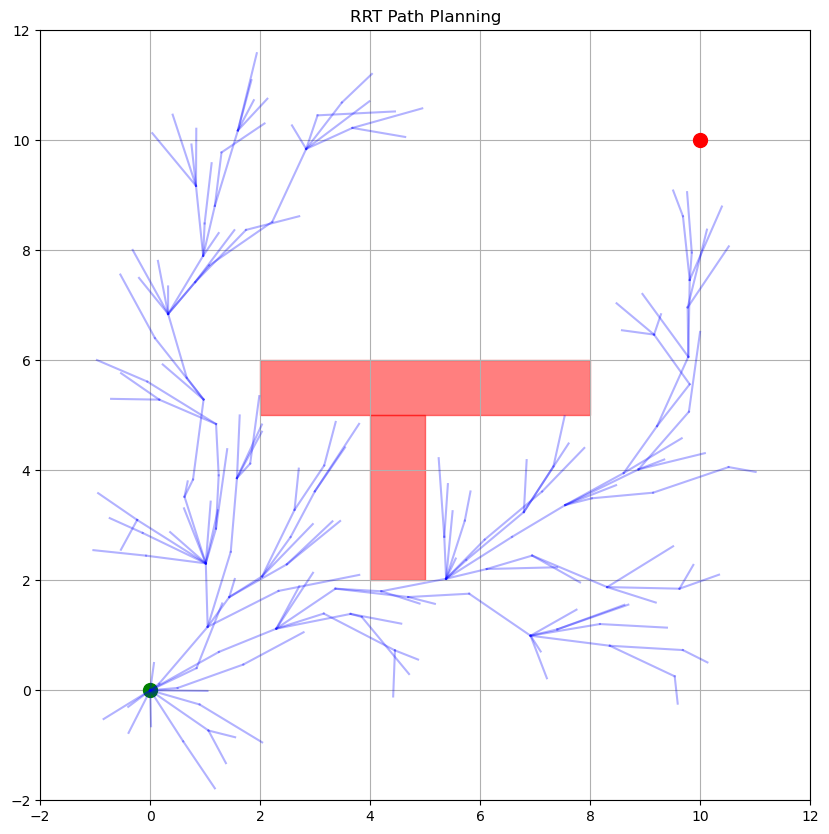

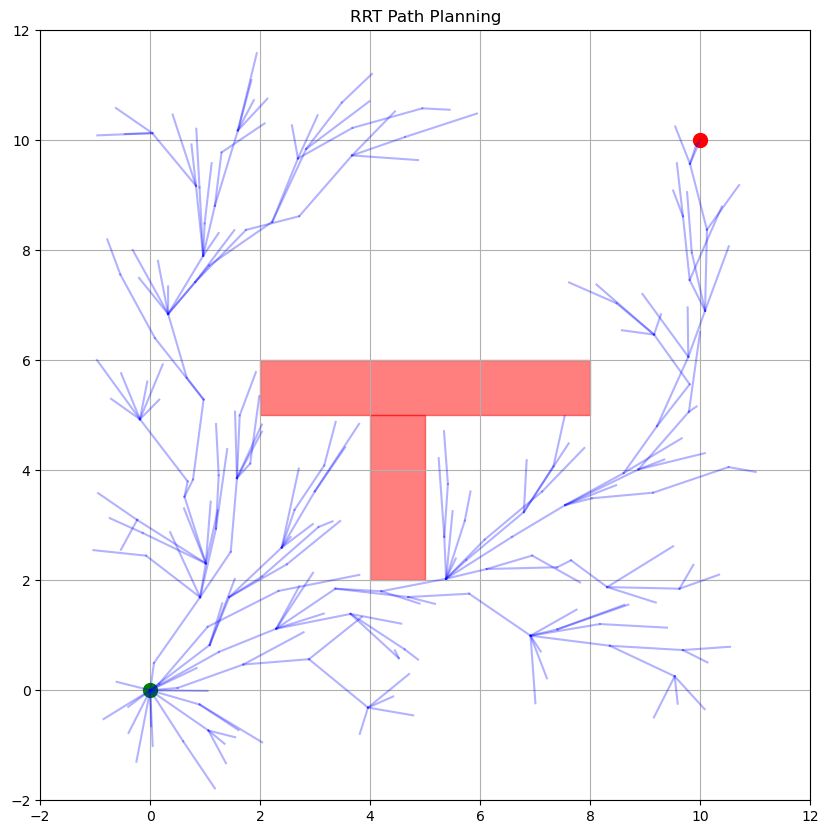

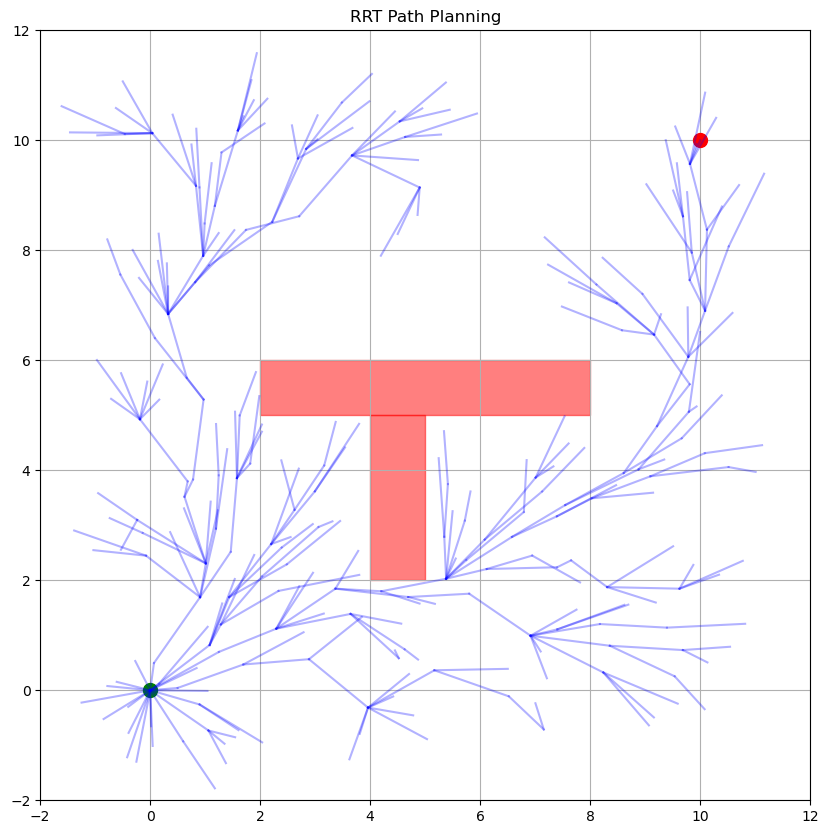

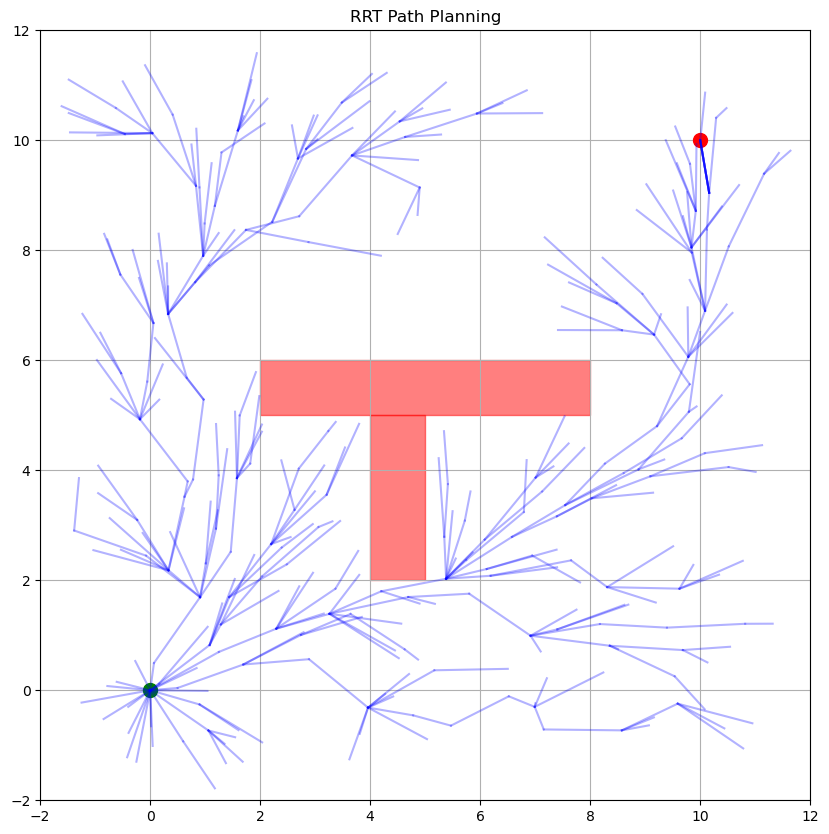

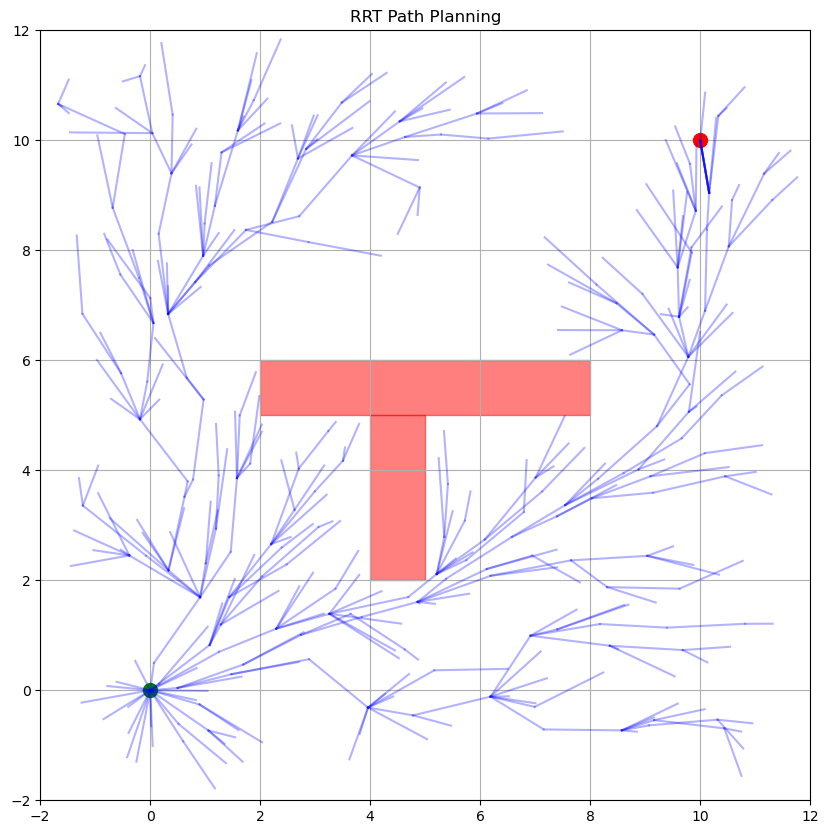

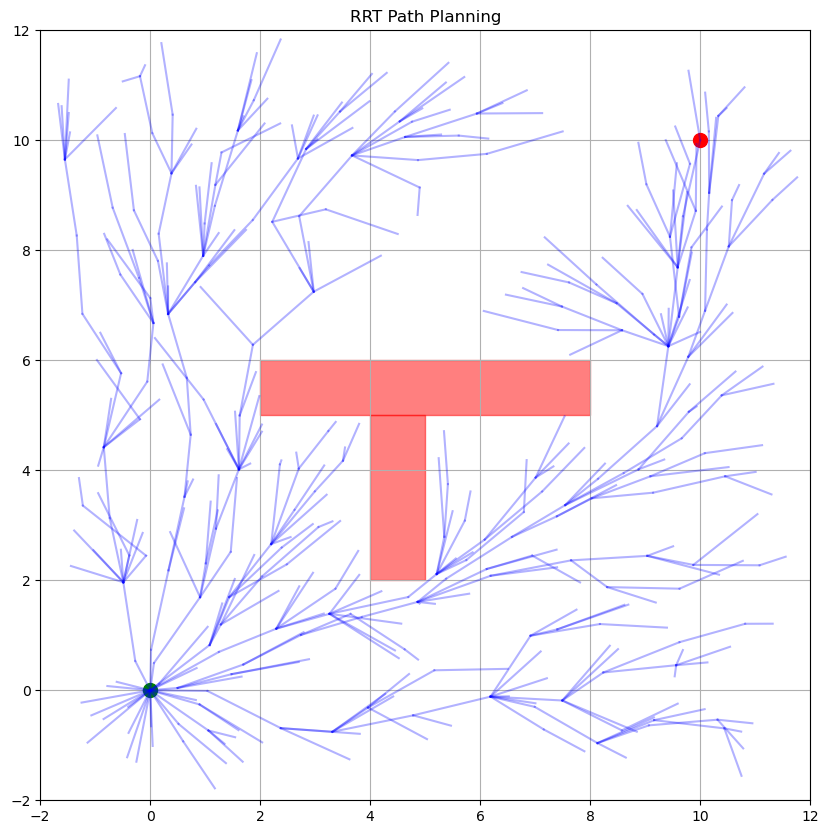

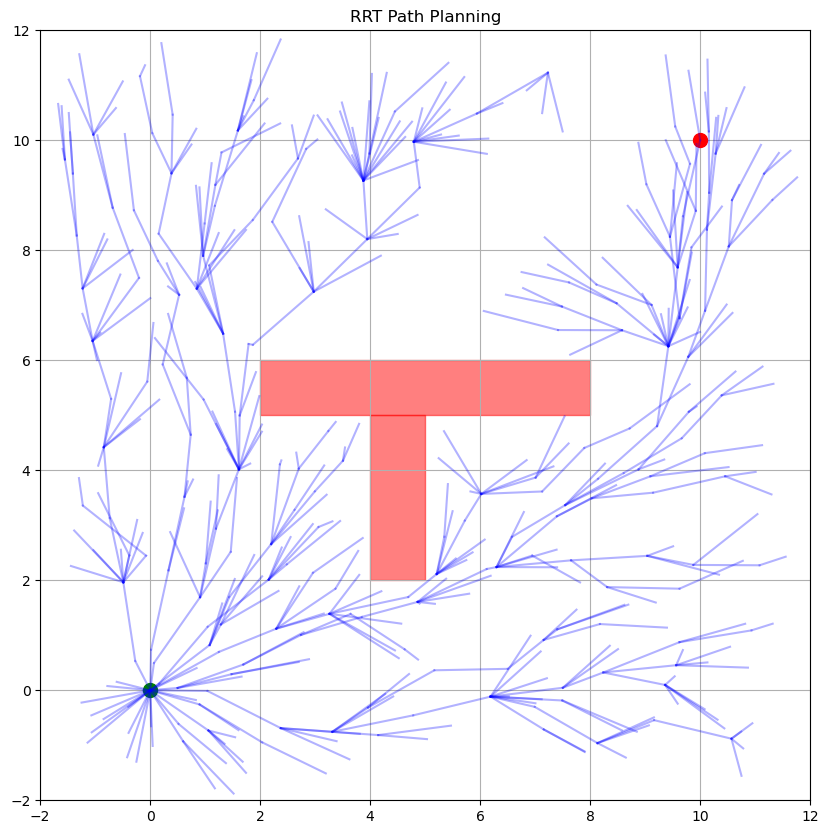

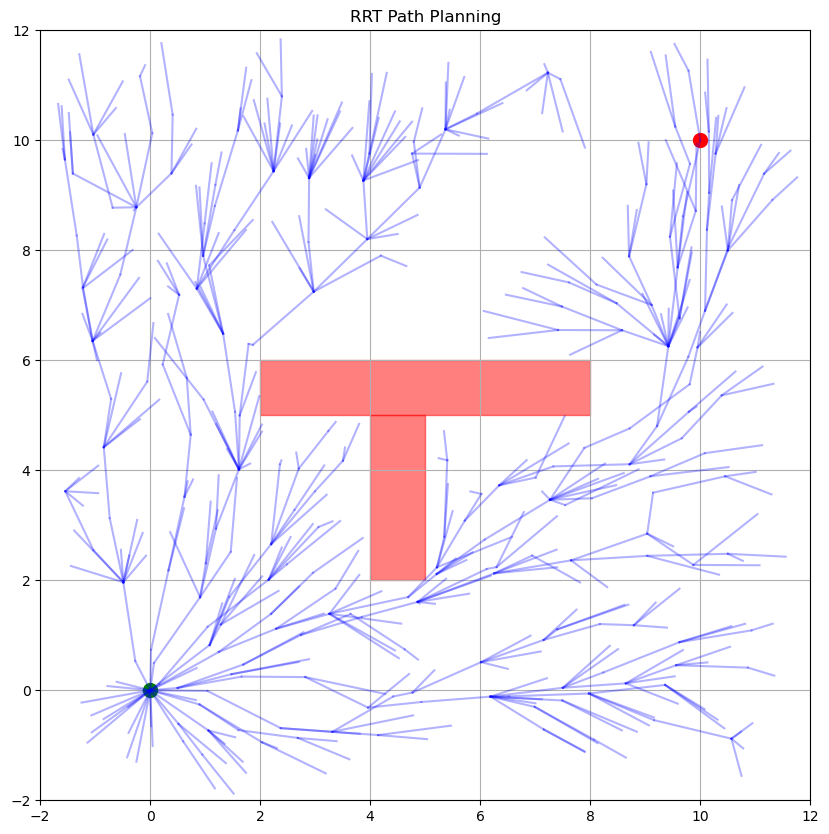

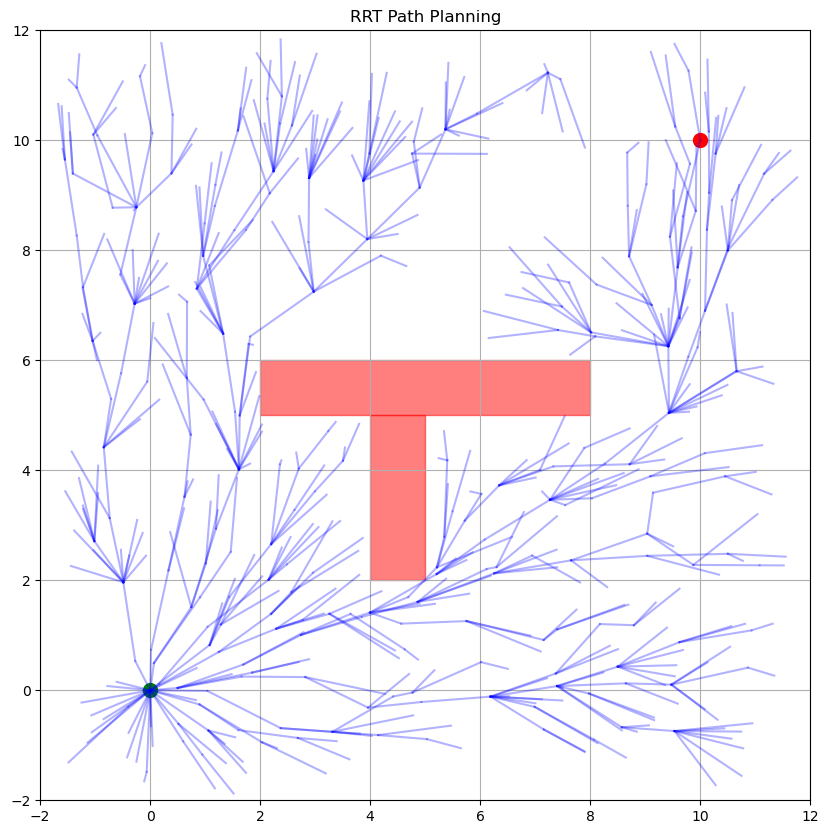

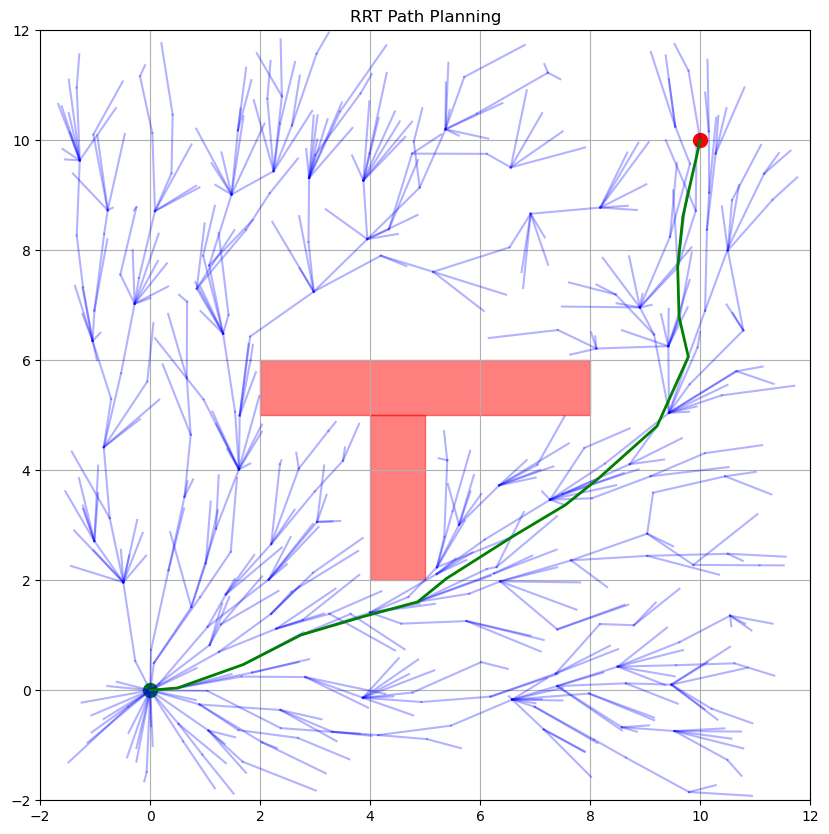

ValueError: too many values to unpack (expected 2)

In [22]:

plt.close("all")
rrt = RRTStar()

obstacle_1 = Obstacle(4, 2, 1, 5)
rrt.add_obstacle(Obstacle(4, 2, 1, 3))
rrt.add_obstacle(Obstacle(2, 5, 6, 1))

success, iterations = rrt.run_rrt_star([0, 0], [10, 10])


if success:
    print(f"Path found in {iterations} iterations!")
    print("Path:", rrt.path)
    print("Path Length:", len(rrt.path))
else:
    print(f"Failed to find path after {iterations} iterations.")